In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from pandas.io.json import json_normalize
import json
import os
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline

In [2]:
def load_df(csv_path='/home/baitong/pywork/RevenuePrediction/all/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
#     print(df.head())
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
path = '/home/baitong/pywork/RevenuePrediction/'

In [4]:
%%time
train = load_df()
test = load_df(csv_path='/home/baitong/pywork/RevenuePrediction/all/test.csv')


Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 3min 50s, sys: 4.11 s, total: 3min 55s
Wall time: 3min 55s


In [5]:
#获取不变的常量列，模型无法在常量数据计学到东西，数据与处理时需要drop
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1 ]
print(const_cols)


['socialEngagementType', 'device_browserSize', 'device_browserVersion', 'device_flashVersion', 'device_language', 'device_mobileDeviceBranding', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_operatingSystemVersion', 'device_screenColors', 'device_screenResolution', 'geoNetwork_cityId', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_networkLocation', 'totals_visits', 'trafficSource_adwordsClickInfo.criteriaParameters']


In [6]:
train = train.drop(const_cols , axis=1)
test = test.drop(const_cols, axis=1)

In [7]:
train['depth']=train['trafficSource_referralPath'][train['trafficSource_referralPath'].notnull()].apply(lambda x:x.count('/'))
test['depth']=test['trafficSource_referralPath'][test['trafficSource_referralPath'].notnull()].apply(lambda x:x.count('/'))
# train['length']=train['trafficSource_referralPath'][train['trafficSource_referralPath'].notnull()].apply(lambda x:len(x))#例子里好像没有放在特征里
# train['path_complexity']=train['trafficSource_referralPath'][train['trafficSource_referralPath'].notnull()].apply(lambda x:train['depth']/train['length'])

In [8]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_campaignCode', 'trafficSource_isTrueDirect',
       'trafficSource_keyword', 'trafficSource_medium',
       'trafficSource_referralPath', 'trafficSource_source', 'depth'],


In [9]:
##将缺失值表示统一
def replaceCatNa(df):
    Nalist = ['(not set)','0','not available in demo dataset','unknown.unknown','(not provided)','(none)']
    catlist = ['device_browser','device_operatingSystem','geoNetwork_city','geoNetwork_continent',
              'geoNetwork_metro','geoNetwork_networkDomain','geoNetwork_region','geoNetwork_subContinent',
              'trafficSource_campaign','trafficSource_keyword','trafficSource_medium']
    for col in catlist:
        df[col] = df[col].astype('str') 
        df[col] = df[col].apply(lambda x : np.nan if x in Nalist else x)
    return df

In [10]:
train = replaceCatNa(train)
test = replaceCatNa(test)

In [11]:
# 去除test中不存在的列
train.drop('trafficSource_campaignCode',inplace = True,axis = 1)

In [12]:
train.shape,test.shape

((903653, 36), (804684, 35))

In [13]:
###将时间戳转换为标准时间表示
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
test.visitStartTime = pd.to_datetime(test.visitStartTime, unit='s')
train["date"] = train.visitStartTime
test["date"] = test.visitStartTime

In [14]:
for df in [train, test]:
    df['weekday'] = df['date'].dt.dayofweek.astype(object)
    df['time'] = df['date'].dt.second + df['date'].dt.minute*60 + df['date'].dt.hour*3600
    df['month'] = df['date'].dt.month   # it must not be included in features during learning!
    df['day'] = df['date'].dt.date       # it must not be included in features during learning!
    df['hours'] = df['date'].dt.hour

In [15]:
####5，6为双休日
train['hours'].value_counts()

18    51096
17    50797
16    49039
15    48092
19    47911
20    46753
14    44490
21    44057
13    40176
22    39584
23    35690
12    34487
0     33482
1     32512
2     32063
3     31235
7     31121
11    30904
8     30889
9     30184
4     29942
10    29869
6     29696
5     29584
Name: hours, dtype: int64

In [16]:
###增加特征 ：是否为双休日
train['isWeekend'] = train['weekday'].apply(lambda x:1 if x>=5 else 0)
test['isWeekend'] = test['weekday'].apply(lambda x:1 if x>=5 else 0)

In [17]:
###填补totals.pageviews值
predmis = train[train['totals_pageviews'].isnull()]['totals_hits'].values
train.loc[(train['totals_pageviews'].isnull()),'totals_pageviews' ] = predmis

predmis = test[test['totals_pageviews'].isnull()]['totals_hits'].values
test.loc[(test['totals_pageviews'].isnull()),'totals_pageviews' ] = predmis

In [18]:
####增加特征：浏览器是否为Chrome
train['isChrome'] = train['device_browser'].apply(lambda x:1 if x=='Chrome' else 0)
test['isChrome'] = test['device_browser'].apply(lambda x:1 if x=='Chrome' else 0)

In [19]:
####增加特征：source是否为youtube ,mail.googleplex.com youtube.com
train['trafficSource_source'].astype('str',inplace = True)
test['trafficSource_source'].astype('str',inplace = True)
train['s_ismall'] = train['trafficSource_source'].apply(lambda x:1 if x=='mall.googleplex.com' else 0)
test['s_ismall'] = test['trafficSource_source'].apply(lambda x:1 if x=='mall.googleplex.com' else 0)

train['s_isyoutube'] = train['trafficSource_source'].apply(lambda x:1 if x=='youtube.com' else 0)
test['s_isyoutube'] = test['trafficSource_source'].apply(lambda x:1 if x=='youtube.com' else 0)

In [20]:
##增加特征：是否为desktop
train['d_isdesktop'] = train['device_deviceCategory'].apply(lambda x:1 if x=='desktop' else 0)
test['d_isdesktop'] = test['device_deviceCategory'].apply(lambda x:1 if x=='desktop' else 0)

train['d_Macintosh'] = train['device_operatingSystem'].apply(lambda x:1 if x=='Macintosh' else 0)
test['d_Macintosh'] = test['device_operatingSystem'].apply(lambda x:1 if x=='Macintosh' else 0)

train['d_Macintosh'] = train['device_operatingSystem'].apply(lambda x:1 if x=='Macintosh' else 0)
test['d_Macintosh'] = test['device_operatingSystem'].apply(lambda x:1 if x=='Macintosh' else 0)

train['d_Linux'] = train['device_operatingSystem'].apply(lambda x:1 if x=='Linux' else 0)
test['d_Linux'] = test['device_operatingSystem'].apply(lambda x:1 if x=='Linux' else 0)

train['d_iOS'] = train['device_operatingSystem'].apply(lambda x:1 if x=='iOS' else 0)
test['d_iOS'] = test['device_operatingSystem'].apply(lambda x:1 if x=='iOS' else 0)

train['d_Android'] = train['device_operatingSystem'].apply(lambda x:1 if x=='Android' else 0)
test['d_Android'] = test['device_operatingSystem'].apply(lambda x:1 if x=='Android' else 0)

train['d_Windows Phone'] = train['device_operatingSystem'].apply(lambda x:1 if x=='Windows Phone' else 0)
test['d_Windows Phone'] = test['device_operatingSystem'].apply(lambda x:1 if x=='Windows Phone' else 0)


In [21]:
train['channel_referral'] = train['channelGrouping'].apply(lambda x:1 if x=='Referral' else 0)
train['channel_Social'] = train['channelGrouping'].apply(lambda x:1 if x=='Social' else 0)
test['channel_referral'] = test['channelGrouping'].apply(lambda x:1 if x=='Referral' else 0)
test['channel_Social'] = test['channelGrouping'].apply(lambda x:1 if x=='Social' else 0)

In [22]:
def dealbrowser(s):
    if s == "Safari "or s == "Firefox":
        return "mainstream"
    elif s == "Chrome":
        return "Chrome"
    else:
        return "others"
train['browser'] = train['device_browser'].apply(dealbrowser)

In [23]:
##增加特征：是否为desktop
train['m_referral'] = train['trafficSource_medium'].apply(lambda x:1 if x=='referral' else 0)
test['m_referral'] = test['trafficSource_medium'].apply(lambda x:1 if x=='referral' else 0)

In [24]:
train['single_visit'] = train['visitNumber'].apply(lambda x:0 if x!=1 else 1)
test['single_visit'] = test['visitNumber'].apply(lambda x:0 if x!=1 else 1)

train['totals_hits'] = train['totals_hits'].astype('float') 
test['totals_hits'] = test['totals_hits'].astype('float') 
train['totals_pageviews'] = train['totals_pageviews'].astype('float') 
test['totals_pageviews'] = test['totals_pageviews'].astype('float') 
train['hits_ratio'] = train['totals_hits']/train['totals_pageviews']
test['hits_ratio'] = test['totals_hits']/test['totals_pageviews']

# tr_te[, single_visit := ifelse(visitNumber == 1,1,0) ]
#     tr_te[, hits_ratio := as.numeric(hits)/as.numeric(pageviews)]
#     tr_te[, domain_site := gsub("^.*\\.","", networkDomain)]
#     tr_te[, adwordsClickInfo.isVideoAd := ifelse(is.na(adwordsClickInfo.isVideoAd), 1, 0)]


In [25]:
##去除离群点'Anguilla'
train =train.drop(index = train['geoNetwork_country'][train['geoNetwork_country']=='Anguilla'].index)

In [26]:
def dealMissingData(df):
    for c in df.columns:
        num_missing = df[c].isnull().sum() 
        if num_missing != 0:
            print("missing col is  ",c,'   missing num is',num_missing)
    print('*'*20)
    num_feature = ["totals_bounces","totals_newVisits",'depth','trafficSource_adwordsClickInfo.page']
    cat_feature = ['trafficSource_adContent','trafficSource_adContent',
                  'trafficSource_campaign','trafficSource_isTrueDirect',
                  'trafficSource_keyword','trafficSource_referralPath',
                  'device_browser','device_operatingSystem','geoNetwork_city',
                  'geoNetwork_continent','geoNetwork_metro','geoNetwork_networkDomain',
                  'geoNetwork_region','geoNetwork_subContinent','trafficSource_adwordsClickInfo.adNetworkType',
                  'trafficSource_adwordsClickInfo.isVideoAd','trafficSource_medium','trafficSource_adwordsClickInfo.slot']
    for col in num_feature:
        df[col].fillna(0,inplace=True)
    for col in cat_feature:
        df[col].fillna(0,inplace=True)
    for c in df.columns:
        num_missing = df[c].isnull().sum() 
        if num_missing != 0:
            print("now missing col is  ",c,'   missing num is',num_missing)
    print('---------------done---------------')
    return df

In [27]:
train = dealMissingData(train)
test = dealMissingData(test)

missing col is   device_browser    missing num is 15
missing col is   device_operatingSystem    missing num is 4695
missing col is   geoNetwork_city    missing num is 542490
missing col is   geoNetwork_continent    missing num is 1468
missing col is   geoNetwork_metro    missing num is 709994
missing col is   geoNetwork_networkDomain    missing num is 390914
missing col is   geoNetwork_region    missing num is 536055
missing col is   geoNetwork_subContinent    missing num is 1468
missing col is   totals_bounces    missing num is 453022
missing col is   totals_newVisits    missing num is 200593
missing col is   totals_transactionRevenue    missing num is 892138
missing col is   trafficSource_adContent    missing num is 892706
missing col is   trafficSource_adwordsClickInfo.adNetworkType    missing num is 882192
missing col is   trafficSource_adwordsClickInfo.gclId    missing num is 882091
missing col is   trafficSource_adwordsClickInfo.isVideoAd    missing num is 882192
missing col is  

In [28]:
def clearRare(columnname, limit = 1000):
    # you may search for rare categories in train, train&test, or just test
    #vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    vc = test[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")
    
    train.loc[train[columnname].map(lambda x: x not in common), columnname] = 'other'
    test.loc[test[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", train[columnname].nunique(), "categories in train")

In [29]:
###数量过少的数据无参考价值，统一归为others
clearRare("device_browser")
clearRare("device_operatingSystem")
clearRare("geoNetwork_country")
clearRare("geoNetwork_city")
clearRare("geoNetwork_metro")
clearRare("geoNetwork_networkDomain")
clearRare("geoNetwork_region")
clearRare("geoNetwork_subContinent")
clearRare("trafficSource_adContent")
clearRare("trafficSource_campaign")
clearRare("trafficSource_keyword")
clearRare("trafficSource_medium")
clearRare("trafficSource_referralPath")
clearRare("trafficSource_source")

Set 98 device_browser categories to 'other'; now there are 11 categories in train
Set 15 device_operatingSystem categories to 'other'; now there are 8 categories in train
Set 160 geoNetwork_country categories to 'other'; now there are 60 categories in train
Set 656 geoNetwork_city categories to 'other'; now there are 76 categories in train
Set 86 geoNetwork_metro categories to 'other'; now there are 23 categories in train
Set 25689 geoNetwork_networkDomain categories to 'other'; now there are 61 categories in train
Set 314 geoNetwork_region categories to 'other'; now there are 61 categories in train
Set 5 geoNetwork_subContinent categories to 'other'; now there are 19 categories in train
Set 46 trafficSource_adContent categories to 'other'; now there are 4 categories in train
Set 23 trafficSource_campaign categories to 'other'; now there are 5 categories in train
Set 2409 trafficSource_keyword categories to 'other'; now there are 8 categories in train
Set 0 trafficSource_medium categor

In [30]:
train.set_index("visitStartTime", inplace=True)
test.set_index("visitStartTime", inplace=True)
train.sort_index(inplace=True)
test.sort_index(inplace=True)

In [31]:
###增加上一次会话和下一次会话的时间间隔，时间间隔越短说明用户购买商品欲望更强烈
df = pd.concat([train, test])
df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
df['prev_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
df['next_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60
df.sort_index(inplace=True)

train = df[:len(train)]
test = df[len(train):]

/home/baitong/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [32]:
##将缺失的0 转换为字符串格式
str_feature = ['trafficSource_adContent','trafficSource_campaign','trafficSource_isTrueDirect',
              'trafficSource_keyword','trafficSource_referralPath',
              'device_browser','device_operatingSystem','geoNetwork_city',
              'geoNetwork_continent','geoNetwork_metro','geoNetwork_networkDomain',
              'geoNetwork_region','geoNetwork_subContinent','trafficSource_adwordsClickInfo.adNetworkType',
              'trafficSource_adwordsClickInfo.isVideoAd','trafficSource_medium','trafficSource_adwordsClickInfo.slot']
for df in [train, test]:
    for col in str_feature:
        df[col] = df[col].astype('str')

In [33]:
##组合特征
for df in [train, test]:
    df['source_country'] = df['trafficSource_source'] + '_' + df['geoNetwork_country']
    df['campaign_medium'] = df['trafficSource_campaign'] + '_' + df['trafficSource_medium']
    df['browser_category'] = df['device_browser'] + '_' + df['device_deviceCategory']
    df['browser_os'] = df['device_browser'] + '_' + df['device_operatingSystem']

In [34]:
##组合特征
for df in [train, test]:
    df['device_deviceCategory_channelGrouping'] = df['device_deviceCategory'] + "_" + df['channelGrouping']
    df['channelGrouping_browser'] = df['device_browser'] + "_" + df['channelGrouping']
    df['channelGrouping_OS'] = df['device_operatingSystem'] + "_" + df['channelGrouping']
    
    for i in ['geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country','geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region','geoNetwork_subContinent']:
        for j in ['device_browser','device_deviceCategory', 'device_operatingSystem', 'trafficSource_source']:
            df[i + "_" + j] = df[i] + "_" + df[j]
    
    df['content_source'] = df['trafficSource_adContent'].astype(str) + "_" + df['source_country']
    df['medium_source'] = df['trafficSource_medium'] + "_" + df['source_country']

In [35]:
##针对用户增加点击浏览量均值特征，以及访问人数最大值特征
for feature in ["totals_hits", "totals_pageviews"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].mean()
    train["usermean_" + feature] = train.fullVisitorId.map(info)
    test["usermean_" + feature] = test.fullVisitorId.map(info)
    
for feature in ["visitNumber"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].max()
    train["usermax_" + feature] = train.fullVisitorId.map(info)
    test["usermax_" + feature] = test.fullVisitorId.map(info)

In [36]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals_transactionRevenue', 'visitId', 'visitStartTime', 
            'month', 'day','trafficSource_adwordsClickInfo.gclId']

cat_cols = [f for f in train.columns if (train[f].dtype == 'object' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]
print("cat_cols num: ",len(cat_cols))
print("cat_cols: ",cat_cols)
print("real_cols num: ",len(real_cols))
print("real_cols: ",real_cols)

cat_cols num:  63
cat_cols:  ['browser', 'channelGrouping', 'device_browser', 'device_deviceCategory', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'totals_bounces', 'totals_newVisits', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_isTrueDirect', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source', 'weekday', 'source_country', 'campaign_medium', 'browser_category', 'browser_os', 'device_deviceCategory_channelGrouping', 'channelGrouping_browser', 'channelGrouping_OS', 'geoNetwork_city_device_browser', 'geoNetwork_city_device_deviceCategory', 'geoNetwork_city_device_operatingSystem', 'geoNetwork_city_trafficSou

In [37]:
y_reg = train['totals_transactionRevenue']

In [38]:
from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [39]:
for col in real_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

In [568]:
train['r_status'] = train['totals_transactionRevenue'].fillna(0).astype("float").apply(lambda x : 1 if x>0 else 0)

In [569]:
def get_folds(df=None, n_splits=5):
    """Returns dataframe indices corresponding to Visitors Group KFold"""
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [570]:
train_features = real_cols + cat_cols
y_clf=train["r_status"].astype("float")

In [571]:
y_clf.value_counts()

0.0    892138
1.0     11514
Name: r_status, dtype: int64

In [572]:
# from xgboost import XGBClassifier
import xgboost as xgb
xgb_params = {
#         'objective': "binary:logistic",
        'objective':'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'learning_rate': 0.2,
        'max_depth': 8,
        'min_child_weight': 30,
        'eta':0.2/100,
        'gamma' : 0,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.5,
        'colsample_bytree': 0.5,
        'colsample_bylevel': 0.632,
        'n_jobs': -1,
        'random_state': 456,
#         'nroubds' : 100
    }
folds = get_folds(df=train, n_splits=5)
xgb_oof_preds = np.zeros(train.shape[0],dtype = "float")
xgb_sub_preds = np.zeros(test.shape[0],dtype = "float")
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features].iloc[trn_], y_clf.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_clf.iloc[val_]
    
    
    dtrain=xgb.DMatrix(trn_x,label=trn_y)
    dval=xgb.DMatrix(val_x,label=val_y)
    
    evallist = [(dval, 'eval'), (dtrain, 'train')]
    bst=xgb.train(xgb_params,dtrain,num_boost_round=100,evals = evallist,early_stopping_rounds=10)
#     xgb = XGBClassifier(**xgb_params, n_estimators=100,objective='binary:logistic')
    
#     xgb.fit(trn_x, trn_y,
#             eval_set=[(val_x, val_y)],
#             early_stopping_rounds=10,
#             eval_metric='auc',
#             verbose=10
#             )
    
    xgb_oof_preds[val_] = bst.predict(dval)
    xgb_oof_preds[val_][:100]
    xgb_oof_preds[xgb_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    dtest = xgb.DMatrix(test[train_features])
    _preds = bst.predict(dtest)
    _preds[_preds < 0] = 0
    xgb_sub_preds += _preds / len(folds)
    
mean_squared_error(y_clf, xgb_oof_preds) ** .5

[19:06:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[0]	eval-auc:0.953838	train-auc:0.962761
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[19:06:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=8
[1]	eval-auc:0.978258	train-auc:0.981076
[19:06:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-auc:0.98386	train-auc:0.986102
[19:06:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-auc:0.984409	train-auc:0.986341
[19:06:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=8
[4]	eval-auc:0.983783	train-auc:0.986126
[19:06:40] /workspace/src/tree/up

[19:07:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[49]	eval-auc:0.988954	train-auc:0.990955
[19:07:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[50]	eval-auc:0.988964	train-auc:0.990968
[19:07:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[51]	eval-auc:0.988977	train-auc:0.990986
[19:07:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-auc:0.988977	train-auc:0.991016
[19:07:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-auc:0.988983	train-auc:0.991035
[19:07:04] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[54]	eval-auc:0.988995	train-auc:0.99106
[19:07:04] 

[19:07:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[99]	eval-auc:0.988981	train-auc:0.99214
[19:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[0]	eval-auc:0.975609	train-auc:0.979824
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[19:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[1]	eval-auc:0.982466	train-auc:0.985882
[19:07:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-auc:0.985091	train-auc:0.986818
[19:07:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[3]	eval-auc:0.985748	train-auc:0.98712
[19:07:33] /workspace/src/tree/upd

[19:07:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[48]	eval-auc:0.989326	train-auc:0.990739
[19:07:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[49]	eval-auc:0.989318	train-auc:0.990745
[19:07:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[50]	eval-auc:0.989339	train-auc:0.990762
[19:07:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[51]	eval-auc:0.989336	train-auc:0.990791
[19:07:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-auc:0.989373	train-auc:0.990832
[19:07:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=8
[53]	eval-auc:0.989366	train-auc:0.99088
[19:07:56] 

[19:08:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[98]	eval-auc:0.989765	train-auc:0.991892
[19:08:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[99]	eval-auc:0.989756	train-auc:0.991909
[19:08:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[0]	eval-auc:0.982747	train-auc:0.983918
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[19:08:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=8
[1]	eval-auc:0.982491	train-auc:0.984867
[19:08:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=8
[2]	eval-auc:0.982427	train-auc:0.985091
[19:08:24] /workspace/src/tree/u

[19:08:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[47]	eval-auc:0.988895	train-auc:0.990874
[19:08:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[48]	eval-auc:0.988912	train-auc:0.990903
[19:08:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[49]	eval-auc:0.988947	train-auc:0.990932
[19:08:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=8
[50]	eval-auc:0.988967	train-auc:0.990978
[19:08:47] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[51]	eval-auc:0.988967	train-auc:0.990988
[19:08:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[52]	eval-auc:0.988975	train-auc:0.991026
[19:08:48]

[19:09:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[97]	eval-auc:0.989166	train-auc:0.992044
[19:09:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[98]	eval-auc:0.989169	train-auc:0.99207
[19:09:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=8
[99]	eval-auc:0.989174	train-auc:0.992079
[19:09:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[0]	eval-auc:0.946511	train-auc:0.958937
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[19:09:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=8
[1]	eval-auc:0.972654	train-auc:0.975854
[19:09:17] /workspace/src/tree/up

[19:09:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=8
[46]	eval-auc:0.989258	train-auc:0.990783
[19:09:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[47]	eval-auc:0.989277	train-auc:0.990815
[19:09:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[48]	eval-auc:0.98931	train-auc:0.990852
[19:09:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[49]	eval-auc:0.989317	train-auc:0.990899
[19:09:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[50]	eval-auc:0.989329	train-auc:0.990939
[19:09:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[51]	eval-auc:0.989345	train-auc:0.990987
[19:09:41] 

[19:10:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=8
[96]	eval-auc:0.989335	train-auc:0.992045
[19:10:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[97]	eval-auc:0.989328	train-auc:0.992056
[19:10:02] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[98]	eval-auc:0.989324	train-auc:0.992077
[19:10:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[99]	eval-auc:0.989299	train-auc:0.992102
[19:10:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[0]	eval-auc:0.975433	train-auc:0.981842
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[19:10:09] /workspace/src/tree/u

[19:10:30] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[45]	eval-auc:0.989315	train-auc:0.990777
[19:10:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[46]	eval-auc:0.989327	train-auc:0.990815
[19:10:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[47]	eval-auc:0.989336	train-auc:0.990841
[19:10:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[48]	eval-auc:0.989345	train-auc:0.990871
[19:10:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[49]	eval-auc:0.989337	train-auc:0.990889
[19:10:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[50]	eval-auc:0.989342	train-auc:0.990916
[19:10:33]

[19:10:53] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=8
[95]	eval-auc:0.989342	train-auc:0.991949
[19:10:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[96]	eval-auc:0.989366	train-auc:0.991977
[19:10:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[97]	eval-auc:0.989369	train-auc:0.991993
[19:10:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[98]	eval-auc:0.98938	train-auc:0.992022
[19:10:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[99]	eval-auc:0.98939	train-auc:0.992043


0.08919223954739373

In [573]:
# xgb_oof_preds

In [574]:
train_pred_r_status = pd.DataFrame()
test_pred_r_status = pd.DataFrame()
train['pred_r_status']=xgb_oof_preds
test['pred_r_status']=xgb_sub_preds
# train_features=train_features+['pred_r_status']

In [589]:
def score_analyze(pred,target,threshold =0.000025):
    print("Classfier threshold is :",threshold)
    tmp_pred = pred.apply(lambda x:0 if x<threshold else 1)
    err = target[target!=tmp_pred]###分类错误的
    true = target[target==tmp_pred] ####分类正确的  
    
    FN =len(err[err==1]) 
    FP = len(err[err==0])
    
    TP = len(true[true==1])
    TN =len(true[true==0])
    print("无收入被分类有收入    错误数量 ====>>> 假反例 FN: ",FP )   
    print("有收入被分类无收入    错误数量 ====>>> 假正例 FP: ",FN )   
    print("无收入被分类无收入    正确数量 ====>>> 真正例 TP: ",TN)   
    print("有收入被分类有收入    正确数量 ====>>> 真反例 TN: ",TP) 
    
    print("有收入准确率 TP/(TP+FP): ",TP/(TP+FP))  
    print("有收入召回率 TP/(TP+FN): ",TP/(TP+FN)) 
    
    print("无收入准确率 TN/(TN+FN): ",TN/(TN+FN))  
    print("无收入召回率 TN/(TN+FP): ",TN/(TN+FP)) 
    
    return threshold
threshold = score_analyze(train['pred_r_status'],train["r_status"])

Classfier threshold is : 2.5e-05
无收入被分类有收入    错误数量 ====>>> 假反例 FN:  448529
有收入被分类无收入    错误数量 ====>>> 假正例 FP:  0
无收入被分类无收入    正确数量 ====>>> 真正例 TP:  443609
有收入被分类有收入    正确数量 ====>>> 真反例 TN:  11514
有收入准确率 TP/(TP+FP):  0.02502809519979654
有收入召回率 TP/(TP+FN):  1.0
无收入准确率 TN/(TN+FN):  1.0
无收入召回率 TN/(TN+FP):  0.4972425790628804


In [551]:
train['pred_r_status'] = train['pred_r_status'].apply(lambda x:0 if x<threshold else 1)
test['pred_r_status'] = test['pred_r_status'].apply(lambda x:0 if x<threshold else 1)

In [552]:
# train['pred_r_status'].value_counts()

In [553]:
y_reg = train['totals_transactionRevenue'].astype("float")
y_reg.fillna(0,inplace = True)

In [554]:
train_payer = train[train['pred_r_status']==0]
train_zero = train[train['pred_r_status']==1]

test_payer = test[test['pred_r_status']==0]
tset_zero = test[test['pred_r_status']==1]
len(train_payer)


791281

In [555]:
target_None = train['totals_transactionRevenue'][train['pred_r_status']==0].astype("float")

target_None.fillna(0,inplace = True)
len(target_None)

791281

In [590]:
folds = get_folds(df=train, n_splits=5)

train_features = real_cols + cat_cols
importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])
for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train[train_features+['pred_r_status']].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features+['pred_r_status']].iloc[val_], y_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x,np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features +['pred_r_status']
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features+['pred_r_status']], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.64672	valid_0's l2: 2.71168
[200]	valid_0's rmse: 1.64615	valid_0's l2: 2.70983
Early stopping, best iteration is:
[161]	valid_0's rmse: 1.64602	valid_0's l2: 2.70939
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.56899	valid_0's l2: 2.46173
Early stopping, best iteration is:
[120]	valid_0's rmse: 1.5681	valid_0's l2: 2.45893
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.59095	valid_0's l2: 2.53112
Early stopping, best iteration is:
[130]	valid_0's rmse: 1.5895	valid_0's l2: 2.52652
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.55507	valid_0's l2: 2.41823
[200]	valid_0's rmse: 1.55418	valid_0's l2: 2.41548
Early stopping, best iteration is:
[151]	valid_0's rmse: 1.55368	valid_0's l2: 2.41393
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.58182	va

1.5880187501864909

/home/baitong/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


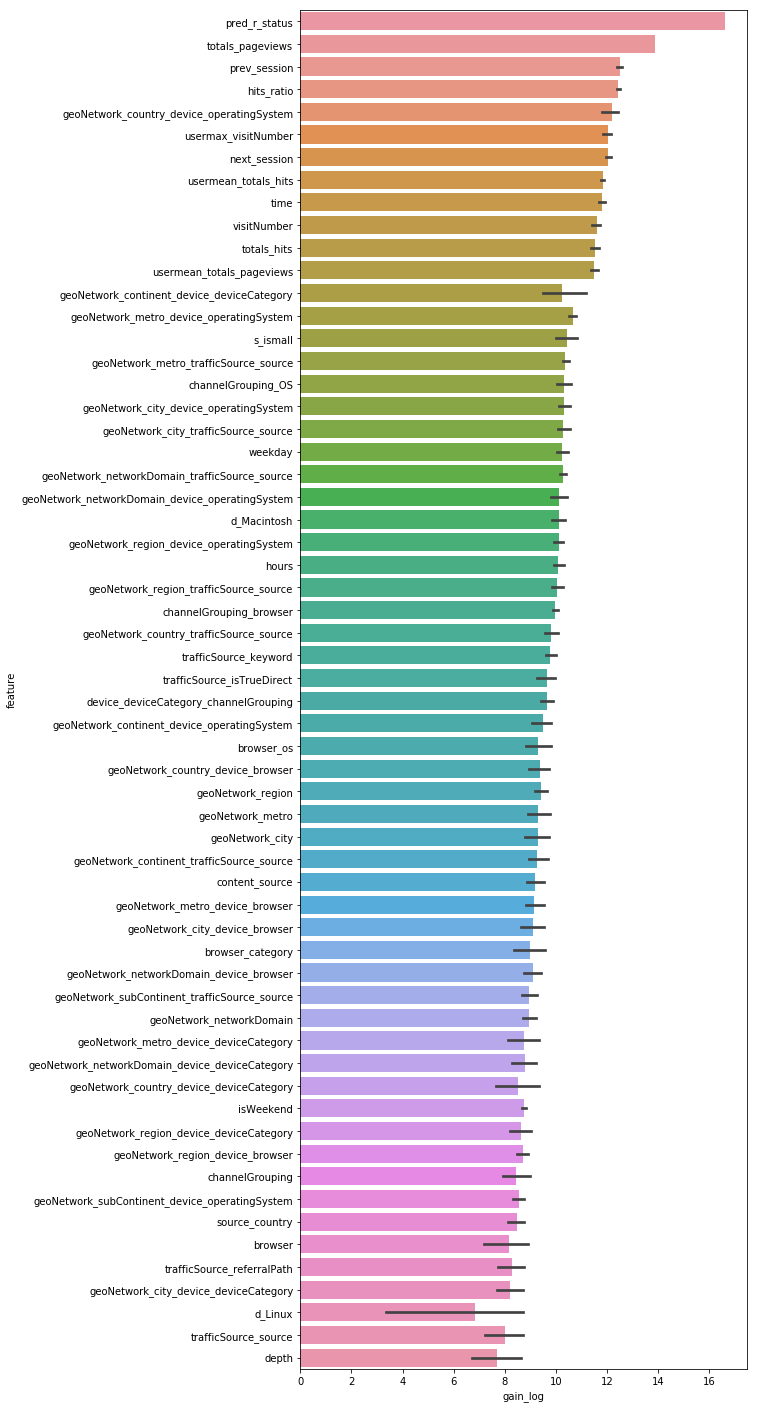

In [597]:
importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False).iloc[:300])

In [591]:
len(oof_reg_preds),len(train)

(903652, 903652)

In [592]:
len(sub_reg_preds),len(test)

(804684, 804684)

In [593]:
train['predictions'] = np.expm1(oof_reg_preds)
test['predictions'] = sub_reg_preds

In [594]:
##计算单个用户会话总数
train["sess_count"]=1;
train_sess_num = train[['fullVisitorId', 'sess_count']].groupby('fullVisitorId').sum()
test["sess_count"]=1;
test_sess_num = test[['fullVisitorId', 'sess_count']].groupby('fullVisitorId').sum()

In [595]:
###将大于20次的会话数量限制为20 （大于20次数据过少）
train_sess_num['sess_count']=train_sess_num['sess_count'].apply(lambda x: 20 if x>20 else x)
test_sess_num['sess_count']=test_sess_num['sess_count'].apply(lambda x: 20 if x>20 else x)

In [598]:
####这里采用均值合并，对于类型特征来说并不合理
train_agg = train[train_features+['pred_r_status']+['fullVisitorId']].groupby('fullVisitorId').mean()

In [599]:
train_pred = train[['fullVisitorId', 'predictions']].groupby('fullVisitorId').sum()
len(train_pred)

714166

In [600]:
train_fulldata = pd.concat([train_agg, train_pred,train_sess_num], axis=1).astype(float)

In [602]:
test_agg = test[train_features+['pred_r_status']+['fullVisitorId']].groupby('fullVisitorId').mean()
test_pred = test[['fullVisitorId', 'predictions']].groupby('fullVisitorId').sum()
test_fulldata = pd.concat([test_agg, test_pred,test_sess_num], axis=1).astype(float)


In [603]:
test_fulldata.shape,train_fulldata.shape

((617242, 93), (714166, 93))

In [604]:
train['target'] = y_reg
trn_user_target = train[['fullVisitorId', 'target']].groupby('fullVisitorId').sum()

In [605]:
folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

lgb_oof_preds = np.zeros(train_fulldata.shape[0])
lgb_sub_preds = np.zeros(test_fulldata.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_fulldata.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_fulldata.iloc[val_], trn_user_target['target'].iloc[val_]
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.03,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(trn_x, np.log1p(trn_y)), (val_x, np.log1p(val_y))],
        eval_names=['TRAIN', 'VALID'],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=100
    )
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = trn_x.columns
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    vis_importances = pd.concat([vis_importances, imp_df], axis=0, sort=False)
    
    lgb_oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    lgb_oof_preds[lgb_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = reg.predict(test_fulldata[train_fulldata.columns], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    lgb_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), lgb_oof_preds) ** .5

Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.51468	TRAIN's l2: 2.29426	VALID's rmse: 1.60735	VALID's l2: 2.58357
Early stopping, best iteration is:
[143]	TRAIN's rmse: 1.49413	TRAIN's l2: 2.23241	VALID's rmse: 1.60409	VALID's l2: 2.57312
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.52398	TRAIN's l2: 2.32251	VALID's rmse: 1.57262	VALID's l2: 2.47313
[200]	TRAIN's rmse: 1.48612	TRAIN's l2: 2.20857	VALID's rmse: 1.56769	VALID's l2: 2.45764
Early stopping, best iteration is:
[203]	TRAIN's rmse: 1.48538	TRAIN's l2: 2.20635	VALID's rmse: 1.56759	VALID's l2: 2.45734
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse: 1.52215	TRAIN's l2: 2.31694	VALID's rmse: 1.58197	VALID's l2: 2.50263
Early stopping, best iteration is:
[149]	TRAIN's rmse: 1.5001	TRAIN's l2: 2.25031	VALID's rmse: 1.57942	VALID's l2: 2.49455
Training until validation scores don't improve for 50 rounds.
[100]	TRAIN's rmse

1.5707276274828192

/home/baitong/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


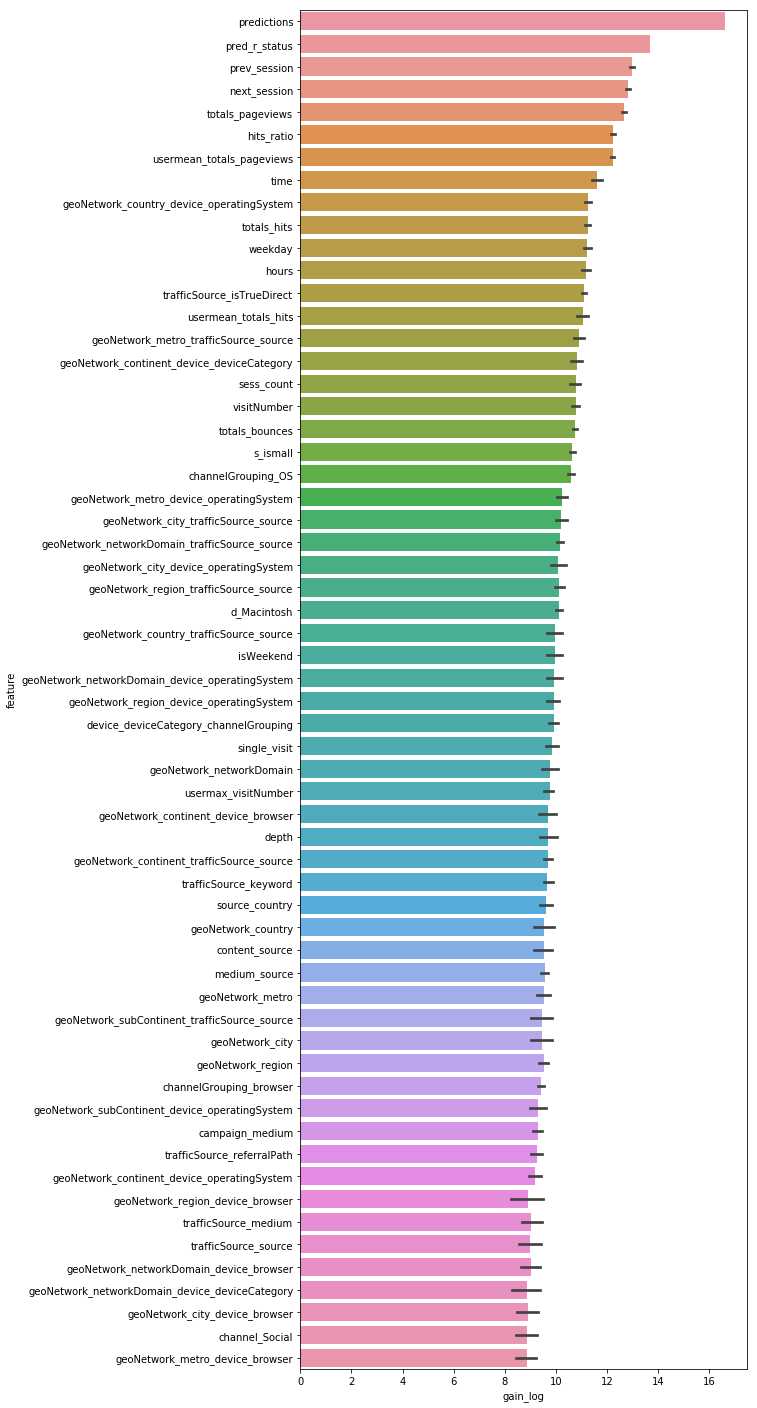

In [606]:
vis_importances['gain_log'] = np.log1p(vis_importances['gain'])
mean_gain = vis_importances[['gain', 'feature']].groupby('feature').mean()
vis_importances['mean_gain'] = vis_importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 25))
sns.barplot(x='gain_log', y='feature', data=vis_importances.sort_values('mean_gain', ascending=False).iloc[:300])

In [607]:
xgb_params = {
        'objective': 'reg:linear',
        'booster': 'gbtree',
        'learning_rate': 0.03,
        'max_depth': 22,
        'min_child_weight': 57,
        'gamma' : 1.45,
        'alpha': 0.0,
        'lambda': 0.0,
        'subsample': 0.67,
        'colsample_bytree': 0.054,
        'colsample_bylevel': 0.50,
        'n_jobs': -1,
        'random_state': 456
    }

In [ ]:
from xgboost import XGBRegressor
folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

xgb_oof_preds = np.zeros(train_fulldata.shape[0])
xgb_sub_preds = np.zeros(test_fulldata.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_fulldata.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_fulldata.iloc[val_], trn_user_target['target'].iloc[val_]
    
    xgb = XGBRegressor(**xgb_params, n_estimators=1300)
    
    xgb.fit(trn_x, np.log1p(trn_y),
            eval_set=[(val_x, np.log1p(val_y))],
            early_stopping_rounds=50,
            eval_metric='rmse',
            verbose = 100)
    xgb_oof_preds[val_] = xgb.predict(val_x)
    xgb_oof_preds[xgb_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = xgb.predict(test_fulldata[train_fulldata.columns])
    _preds[_preds < 0] = 0
    xgb_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), xgb_oof_preds) ** .5

[0]	validation_0-rmse:2.14829
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.75885
[200]	validation_0-rmse:1.68141
[300]	validation_0-rmse:1.65253
[400]	validation_0-rmse:1.63249
[500]	validation_0-rmse:1.6265
[600]	validation_0-rmse:1.62319
[700]	validation_0-rmse:1.61991
[800]	validation_0-rmse:1.61694
[900]	validation_0-rmse:1.61526
Stopping. Best iteration:
[947]	validation_0-rmse:1.61457

[0]	validation_0-rmse:2.10042
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.73162
[200]	validation_0-rmse:1.65352
[300]	validation_0-rmse:1.61587
[400]	validation_0-rmse:1.59602
[500]	validation_0-rmse:1.58518
[600]	validation_0-rmse:1.5796
[700]	validation_0-rmse:1.57758
[800]	validation_0-rmse:1.57616
[900]	validation_0-rmse:1.57488
[999]	validation_0-rmse:1.57404
[0]	validation_0-rmse:2.10237
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:1.73209
[200]	validation_0

In [ ]:
cat_param = {
    'learning_rate' :0.03,
    'depth' :10,
    'eval_metric' :'RMSE',
    'od_type' :'Iter',
    'metric_period ' : 50,
    'od_wait' : 20,
    'seed' : 42
    
}

In [ ]:
from catboost import CatBoostRegressor
folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

cat_oof_preds = np.zeros(train_fulldata.shape[0])
cat_sub_preds = np.zeros(test_fulldata.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_fulldata.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_fulldata.iloc[val_], trn_user_target['target'].iloc[val_]
    
    cat = CatBoostRegressor(iterations=1000,learning_rate=0.03,
                            depth=10,
                            eval_metric='RMSE',
                            random_seed = 42,
                            bagging_temperature = 0.2,
                            od_type='Iter',
                            metric_period = 50,
                            od_wait=20)
    cat.fit(trn_x, np.log1p(trn_y), 
            eval_set=[(val_x, np.log1p(val_y))],
            early_stopping_rounds=50,
            use_best_model=True,
            verbose=100)
    cat_oof_preds[val_] = cat.predict(val_x)
    cat_oof_preds[cat_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = cat.predict(test_fulldata[train_fulldata.columns])
    _preds[_preds < 0] = 0
    cat_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), cat_oof_preds) ** .5

In [ ]:
test_fulldata['lgb_pred'] = lgb_sub_preds
test_fulldata['xgb_pred'] = xgb_sub_preds
test_fulldata['cst_pred'] = cat_sub_preds
test_final_data = test_fulldata[['lgb_pred','xgb_pred','cst_pred']]

In [ ]:
train_fulldata['lgb_pred'] = lgb_oof_preds
train_fulldata['xgb_pred'] = xgb_oof_preds
train_fulldata['cst_pred'] = cat_oof_preds
train_final_data = train_fulldata[['lgb_pred','xgb_pred','cst_pred']]

In [ ]:
from sklearn.linear_model import LinearRegression

folds = get_folds(df=train_fulldata[['totals_pageviews']].reset_index(), n_splits=5)

final_oof_preds = np.zeros(train_final_data.shape[0])
final_sub_preds = np.zeros(test_final_data.shape[0])
vis_importances = pd.DataFrame()

for fold_, (trn_, val_) in enumerate(folds):
    trn_x, trn_y = train_final_data.iloc[trn_], trn_user_target['target'].iloc[trn_]
    val_x, val_y = train_final_data.iloc[val_], trn_user_target['target'].iloc[val_]
    
    lin_reg = LinearRegression()
    lin_reg.fit(trn_x,np.log1p(trn_y))
    final_oof_preds[val_] = lin_reg.predict(val_x)
    final_oof_preds[final_oof_preds < 0] = 0
    
    # Make sure features are in the same order
    _preds = lin_reg.predict(test_final_data[train_final_data.columns])
    _preds[_preds < 0] = 0
    final_sub_preds += _preds / len(folds)
    
mean_squared_error(np.log1p(trn_user_target['target']), final_oof_preds) ** .5